# Tarea 1: Perceptrón Multicapa
### EL4106 Inteligencia Computacional

Profesor de Cátedra: Pablo Estévez<br>
Profesor Auxiliar: Juan Urrutia<br>
Alumno: Diego Dominguez

## Imports

In [1]:
from pathlib import Path
import time

import torch
from torch import nn
import torchvision

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Preparación de la base de datos MNIST

Cargamos los datos de MNIST desde la librería `torchvision`.

La clase torchvision.datasets.MNIST retorna un dataset de pytorch con los ejemplos de las imágenes y sus respectivas clases (un dataset como los que ya hemos visto en la actividad 2). Sin embargo, cada ejemplo es entregado como una imagen PIL. Por esto es necesario definir una transformación que toma la imagen PIL y la pasa a un tensor de pytorch. Además, cada pixel de las imágenes de MNIST tienen valores entre 0 y 255 para la escala de grises (donde 0 es color negro y 255 es color blanco). La transformación ToTensor toma estos valores y los normaliza entre 0 y 1 (básicamente los divide por 255). Por lo tanto, el tensor final entregado es de la forma de la imagen original, donde cada elemento corresponde a un pixel con un valor entre 0 y 1.

Los tensores obtenidos por la transformación ToTensor son de la forma 1x28x28, donde la primera dimensión representa los canales de color. En este caso es escala de grises, por lo que se tiene sólo un canal, pero si la imagen fuese RGB, existirían 3 canales de color y el tensor sería de la forma 3x28x28. Las últimas dos dimensiones representan los pixeles de cada dimensión. En este caso tenemos una imagen de 28x28. Dado que utilizaremos MLP, tenemos que entregar cada dato en forma de vector, por lo que utilizamos la segunda transformación que "aplana" estos tensores, pasando de la forma 1x28x28 a 784. Esta última transformación la hace el objeto `torchvision.transforms.Lambda` que toma una función definida por nosotros y la aplica a cada tensor. En este caso es la función `flatten`, que como su nombre lo dice, aplana los tensores.

La forma de juntar estas dos transformaciones anteriores es utilizando el objeto `torchvision.transforms.Compose` que compone transformaciones (como su nombre lo dice).

Además se define la variable `target_transform` que transforma los labels del dataset. En este caso la transformación toma cada label (números del 0 al 9) y los transforma en un 1 (si el dígito es igual a 8) ó en 0 (si el dígito es distinto a 8). De esta forma pasamos de una tarea de clasificación de 10 dígitos a una tarea de clasificación en la cual queremos identificar si un dígito es un 8 o no. Además podemos cambiar el dígito escogido alterando la variable `chosen_digit`. Para la tarea no cambien esta variable.

Puede cambiar la variable `indice_de_ejemplo` al índice que desee para observar distintas instancias del dataset de entrenamiento.

Para mostrar esta imagen con matplotlib utilizamos la función x.reshape(28, 28), esta toma el tensor y lo transforma nuevamente en un tensor de 28x28. Esto es necesario para mostrar la imagen en matplotlib (pueden revisar la [documentación](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) para ver qué recibe la función imshow).

In [2]:
# Dígito escogido para clasificar
chosen_digit = 8

# Se define una transformación para las imágenes (La primera transforma las imágenes a tensor y la segunda aplana los tensores en vectores)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda t: t.flatten()),
])

# Se define una transformación para los labels. Esta toma cada label y los transforma a 1 y 0,
# donde 1 representa que el dígito es igual al dígito escogido (en este caso 8) y 0 representa que es otro dígito.
target_transform = torchvision.transforms.Lambda(lambda label: 1 if label == chosen_digit else 0)

# Se descargan los datasets de train y test de mnist y se transforman
root_dataset_dir = "./mnist"

train_mnist_dataset = torchvision.datasets.MNIST(
    root=root_dataset_dir,
    train=True,
    transform=transform, # Acá definimos la transformación a las imágenes
    target_transform=target_transform, # Acá definimos la transformación a los labels
    download=True
)
test_mnist_dataset = torchvision.datasets.MNIST(
    root=root_dataset_dir,
    train=False,
    transform=transform, # Acá definimos la transformación a las imágenes
    target_transform=target_transform, # Acá definimos la transformación a los labels
    download=True
)

# Del dataset de entrenamieno obtenemos una porción que utilizaremos como dataset de validación
# Sabemos que son 60000 datos totales del dataset original de entrenamiento y 10000 de test.
# Por lo tanto tomamos 10000 datos del dataset de entrenamiento y los utilizamos como validación (eliminándolos del dataset de entrenamiento)
train_size = 55000
val_size = len(train_mnist_dataset) - train_size
train_mnist_dataset, val_mnist_dataset = torch.utils.data.random_split(train_mnist_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"El dataset de entrenamiento completo tiene: {len(train_mnist_dataset)} elementos.")
print(f"El dataset de validación tiene: {len(val_mnist_dataset)} elementos.")
print(f"El dataset de test tiene: {len(test_mnist_dataset)} elementos.")

print()

x, y = train_mnist_dataset[0]
print(f"Primer ejemplo obtenido del dataset:")
print(f"Tensor de tamaño: {x.shape} con valor mínimo: {x.min()} y máximo: {x.max()}")
print("Clase:", y)

El dataset de entrenamiento completo tiene: 55000 elementos.
El dataset de validación tiene: 5000 elementos.
El dataset de test tiene: 10000 elementos.

Primer ejemplo obtenido del dataset:
Tensor de tamaño: torch.Size([784]) con valor mínimo: 0.0 y máximo: 1.0
Clase: 0


Los datasets anteriores están desbalanceados ya que hay muchos menos 8 que otros números. A continuación los balanceamos muestreando la misma cantidad de dígitos que no son 8 de forma aleatoria.

In [3]:
def balance_dataset(dataset):
    data_tuples = [(x, y) for (x, y) in dataset] # Separamos el dataset en X, y
    X = torch.stack([t[0] for t in data_tuples])
    y = torch.tensor([t[1] for t in data_tuples])

    # Observamos el desbalance
    unique_elements, counts = np.unique(y, return_counts=True)
    if counts[0] == counts[1]:
        print("Dataset ya fue balanceado. Retornando dataset original.")
        return dataset

    print(f"Dataset desbalanceado con {counts[0]} elementos con etiqueta {unique_elements[0]} y {counts[1]} elementos con etiqueta {unique_elements[1]}")

    min_class = unique_elements[np.argmin(counts)]

    other_class_indices = np.random.choice(np.where(y != min_class)[0], size=min(counts), replace=False)
    min_class_indices = np.where(y == min_class)[0]

    total_indices = np.concatenate((other_class_indices, min_class_indices))

    final_X = X[total_indices]
    final_y = y[total_indices]

    # Observamos el dataset balanceado
    unique_elements, counts = np.unique(final_y, return_counts=True)
    print(f"Dataset balanceado con {counts[0]} elementos con etiqueta {unique_elements[0]} y {counts[1]} elementos con etiqueta {unique_elements[1]}")

    final_dataset = torch.utils.data.TensorDataset(
        final_X.float(),
        final_y,
    )

    return final_dataset

In [4]:
print("Balanceando dataset de entrenamiento.")
train_mnist_dataset = balance_dataset(train_mnist_dataset)
print()

print("Balanceando dataset de validación.")
val_mnist_dataset = balance_dataset(val_mnist_dataset)
print()

print("Balanceando dataset de test.")
test_mnist_dataset = balance_dataset(test_mnist_dataset)

Balanceando dataset de entrenamiento.
Dataset desbalanceado con 49653 elementos con etiqueta 0 y 5347 elementos con etiqueta 1
Dataset balanceado con 5347 elementos con etiqueta 0 y 5347 elementos con etiqueta 1

Balanceando dataset de validación.
Dataset desbalanceado con 4496 elementos con etiqueta 0 y 504 elementos con etiqueta 1
Dataset balanceado con 504 elementos con etiqueta 0 y 504 elementos con etiqueta 1

Balanceando dataset de test.
Dataset desbalanceado con 9026 elementos con etiqueta 0 y 974 elementos con etiqueta 1
Dataset balanceado con 974 elementos con etiqueta 0 y 974 elementos con etiqueta 1


Observamos algunos ejemplos y sus respectivas clases

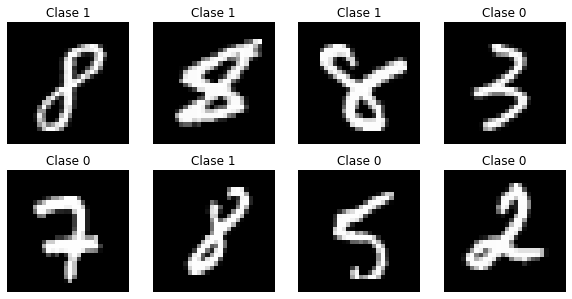

In [5]:
chosen_indices = np.random.RandomState(seed=2).choice(len(train_mnist_dataset), size=8, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for idx, ax in zip(chosen_indices, axes.flat):
    x, y = train_mnist_dataset[idx]
    ax.imshow(x.reshape(28, 28), cmap="gray")
    ax.set_title(f"Clase {y}")
    ax.axis('off')

plt.show()

## Definición de Clasificador MLP

### Función de costo

Definimos nuestras funciones de costo

In [6]:
mse_criterion = nn.MSELoss()
cross_entropy_criterion = nn.BCELoss()

### Clase de Clasificador MLP
Se define el modelo MLP. Este toma como entrada el número de features y una lista con los tamaños de cada capa.

Notemos que la última capa corresponde a una nn.Linear que termina en un valor. Para una clasificación multi-clase, se pondría al final una capa lineal que termine en el número de clases, otorgando una probabilidad para cada clase en cada una de las neuronas de salida. Dado que tenemos una clasificación binaria, tenemos dos formas de definir esto, podemos utilizar dos neuronas de salida, tal que la primera defina la probabilidad de que la clase sea 0 y la segunda la probabilidad de que la clase sea 1. O bien, podemos definirlo como lo hacemos en este caso, donde tenemos una sola salida, tal que esta representa la probabilidad de que la clase sea 1.

Esto último podemos hacerlo ya que sabemos que la probabilidad de que la clase sea 0 es equivalente a $1 - P(C = 1)$.

Si utilizamos esta formulación, entonces podemos usar la función de costo BCELoss (Binary Cross Entropy Loss). Si utilizamos la primera formulación tenemos que usar la función de costo CrossEntropyLoss.

In [7]:
class MLPClassifier(nn.Module):
    def __init__(self, n_features, layer_sizes):
        super().__init__()
        
        """
        Acá definimos las capas ocultas.
        Ejemplo:
        Si recibimos layer_sizes = [10, 20], entonces se creará una red:

        self.net = nn.Sequential(
            nn.Linear(n_features, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
            nn.Sigmoid(),
        )

        Las dos primeras capas (y sus respectivas funciones de activación) se
        definirán en el loop for que se tiene acá abajo. La última capa (y la
        función sigmoide final) se agrega en el append que viene luego del loop for.
        """
        
        layers = []
        prev_size = n_features
        for layer_size in layer_sizes:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.ReLU())
            prev_size = layer_size

        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

### Función de entrenamiento

In [8]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

In [9]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    max_epochs,
    criterion,
    batch_size,
    lr,
    early_stopping_tolerance=15,
    use_gpu=False
):
    if use_gpu:
        model.cuda()

    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": []
    }

    # Early stopping
    n_epochs_with_no_improvement = 0
    stop = False

    t0 = time.perf_counter()

    for epoch in range(max_epochs):
        cumulative_train_loss = 0
        cumulative_train_corrects = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{max_epochs} - Batch {i}/{len(train_loader)}", end="")
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            # Predicción
            y_predicted = model(x_batch)

            y_batch = y_batch.reshape(-1, 1).float()

            # Cálculo de loss
            loss = criterion(y_predicted, y_batch)

            # Actualización de parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cumulative_train_loss += loss.item()

            # Calculamos número de aciertos
            class_prediction = (y_predicted > 0.5)
            cumulative_train_corrects += (y_batch == class_prediction).sum()

        train_loss = cumulative_train_loss / len(train_loader)
        train_acc = cumulative_train_corrects / len(train_dataset)

        # Evaluación del modelo
        model.eval()
        x_val, y_val = next(iter(val_loader))
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        y_val = y_val.reshape(-1, 1).float()
        loss = criterion(y_predicted, y_val)

        class_prediction = (y_predicted > 0.5).long()
        val_acc = (y_val == class_prediction).sum() / y_val.shape[0]
        val_loss = loss.item()

        curves["train_acc"].append(train_acc.item())
        curves["val_acc"].append(val_acc.item())
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        print(f" - Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}")

        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    return curves

## Entrenamiento de MLP

In [10]:


epochs = 100
lr = 1e-1
batch_size = 32
early_stopping_tolerance = 15
use_gpu = False # CAMBIAR ESTO A True SI UTILIZAN UN ENTORNO CON GPU

criterion = nn.BCELoss() # ACÁ SE CAMBIA EL FUNCIONAL DE COSTO PARA EL EXPERIMENTO 1
# criterion = nn.MSELoss()

run_n_times = 5
curves_history = []
for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    # ----- Creacion de MLP
    model = MLPClassifier(
        n_features=28 * 28,
        layer_sizes=[25],
    )

    # ----- Entrenamiento de MLP
    curves = train_model(
        model,
        train_mnist_dataset,
        val_mnist_dataset,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=use_gpu
    )

    print()

    curves_history.append(curves)

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.31692470854787685, Train acc: 0.8683373928070068, Val loss: 0.24727530777454376, Val acc: 0.891865074634552
Epoch 2/100 - Batch 334/335 - Train loss: 0.17588309944788022, Train acc: 0.9373480677604675, Val loss: 0.1501660794019699, Val acc: 0.9573412537574768
Epoch 3/100 - Batch 334/335 - Train loss: 0.13049787034961716, Train acc: 0.9526837468147278, Val loss: 0.13173486292362213, Val acc: 0.9464285969734192
Epoch 4/100 - Batch 334/335 - Train loss: 0.10504029059310013, Train acc: 0.9640920162200928, Val loss: 0.11702170968055725, Val acc: 0.9573412537574768
Epoch 5/100 - Batch 334/335 - Train loss: 0.08825708394175145, Train acc: 0.9705442190170288, Val loss: 0.09261133521795273, Val acc: 0.9672619104385376
Epoch 6/100 - Batch 334/335 - Train loss: 0.0754754098312957, Train acc: 0.9735365509986877, Val loss: 0.12361966818571091, Val acc: 0.9533730149269104
Epoch 7/100 - Batch 334/335 - Train loss: 0.06586349934

### Tasa de acierto en validación computada sobre varias ejecuciones.

In [11]:
val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)

Final validation accuracy 0.973 +/- 0.016
[0.98313493 0.98511904 0.97619045 0.97916669 0.9424603 ]
Final train accuracy 1.000 +/- 0.000
[0.99981296 1.         0.99953246 0.99990648 0.99953246]


## Visualización de Resultados

### Algunas estadísticas del entrenamiento

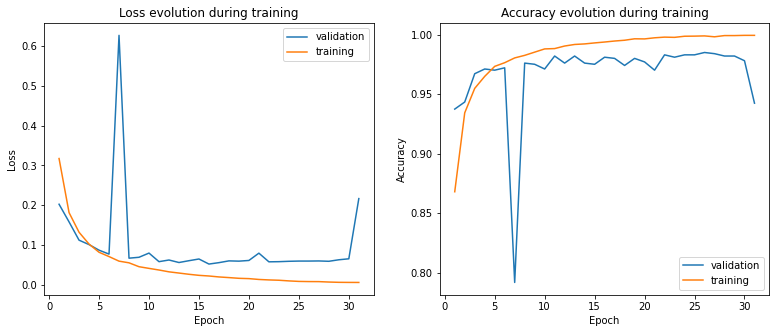

In [12]:
# Obtenemos las curvas del último entrenamiento y las mostramos
last_curves = curves_history[-1]

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

epochs = np.arange(len(last_curves["val_loss"])) + 1

ax[0].plot(epochs, last_curves['val_loss'], label='validation')
ax[0].plot(epochs, last_curves['train_loss'], label='training')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training')
ax[0].legend()

ax[1].plot(epochs, last_curves['val_acc'], label='validation')
ax[1].plot(epochs, last_curves['train_acc'], label='training')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training')
ax[1].legend()

plt.show()

### Estadísticas del desempeño final

In [13]:
def performance_metrics(TP, FP, FN, TN):
    """Calcula metricas de desempeño.
    
    Args:
        TP: Numero de verdaderos positivos.
        FP: Numero de falsos positivos.
        FN: Numero de falsos negativos.
        TN: Numero de verdaderos negativos.
    
    Returns:
        accuracy: Porcentaje de clasificaciones correctas del detector.
        precision: Precision del detector.
        recall: Recall/Sensibilidad del detector.
    """
    accuracy = 100.0 * (TP + TN) / (TP + TN + FP + FN)
    precision = 100.0 * TP / (TP + FP)
    recall = 100.0 * TP / (TP + FN)
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
    print(f"{accuracy:.4f} Accuracy (Porcentaje de clasificaciones correctas)")
    print(f"{precision:.4f} Precision")
    print(f"{recall:.4f} Recall")
    print()
    return accuracy, precision, recall

def roc_curve(labels, probabilities):
    """Calcula la curva ROC.
    
    Args:
        labels: Array binario 1-D con las etiquetas reales.
        probabilities: Array 1-D continuo en el rango [0, 1] con las
            probabilidades de la clase 1.
        
    Returns:
        tpr: Array 1-D con los valores de Tasa de Verdaderos Positivos (TPR).
        fpr: Array 1-D con los valores de Tasa de Falsos Positivos (FPR).
    """
    tpr = []
    fpr = []
    for threshold in np.linspace(0, 1, 1000):
        TN, FP, FN, TP = conf_matrix_given_threshold(labels, probabilities, threshold)
        tpr.append(TP / (TP + FN))
        fpr.append(FP / (FP + TN))

    return np.array(tpr), np.array(fpr)

def conf_matrix_given_threshold(true_labels, prediction, threshold):
    probabilities_with_threshold = (prediction > threshold).long()
    TN, FP, FN, TP = confusion_matrix(true_labels, probabilities_with_threshold).ravel()   
    return TN, FP, FN, TP

In [14]:
X_train, y_train = train_mnist_dataset[:]
X_val, y_val = val_mnist_dataset[:]
X_test, y_test = test_mnist_dataset[:]

train_probabilities = model(X_train).reshape(-1)
val_probabilities = model(X_val).reshape(-1)
test_probabilities = model(X_test).reshape(-1)

train_predicted_labels = (train_probabilities > 0.5).long()
val_predicted_labels = (val_probabilities > 0.5).long()
test_predicted_labels = (test_probabilities > 0.5).long()

TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()

print('Training results:')
TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Validation results:')
TN, FP, FN, TP = confusion_matrix(y_val, val_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Test results:')
TN, FP, FN, TP = confusion_matrix(y_test, test_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

Training results:
TP: 4922, TN: 5347, FP: 0, FN: 425
96.0258 Accuracy (Porcentaje de clasificaciones correctas)
100.0000 Precision
92.0516 Recall

Validation results:
TP: 446, TN: 504, FP: 0, FN: 58
94.2460 Accuracy (Porcentaje de clasificaciones correctas)
100.0000 Precision
88.4921 Recall

Test results:
TP: 880, TN: 968, FP: 6, FN: 94
94.8665 Accuracy (Porcentaje de clasificaciones correctas)
99.3228 Precision
90.3491 Recall



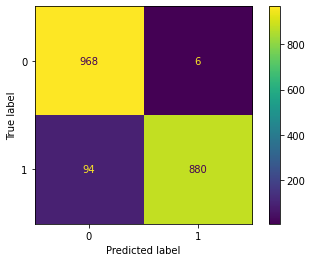

In [15]:
# Graficamos la matriz de confusión de los datos de test
ConfusionMatrixDisplay.from_predictions(y_test, test_predicted_labels)
plt.show()

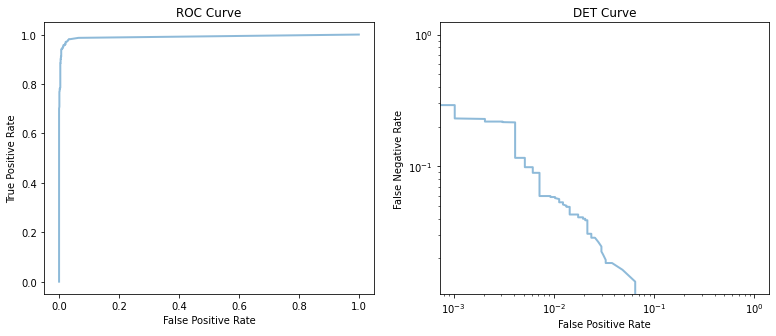

In [16]:
# Graficamos la curva ROC en test
tpr, fpr = roc_curve(y_test, test_probabilities)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

ax[0].set_title('ROC Curve')
ax[0].plot(fpr, tpr, linewidth=2, alpha=0.5)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[1].set_title('DET Curve')
ax[1].plot(fpr, 1.0 - tpr, linewidth=2, alpha=0.5)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('False Negative Rate')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

### Performance según umbral de clasificación

In [17]:
threshold = 0.5
TN, FP, FN, TP = conf_matrix_given_threshold(y_val, val_probabilities, threshold=threshold)
print(f"Threshold: {threshold} | TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

Threshold: 0.5 | TP: 446, TN: 504, FP: 0, FN: 58


### Visualización de clasificaciones en el test

True Positives:


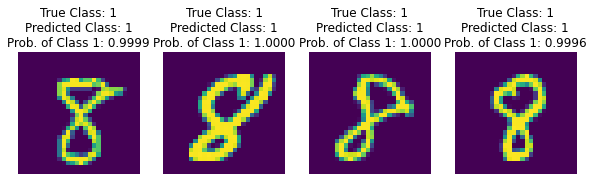

True Negatives:


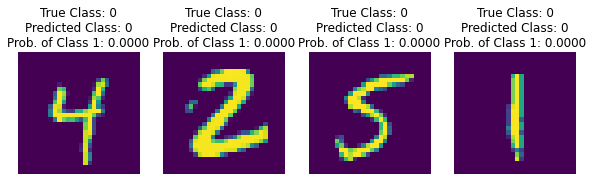

False Positive:


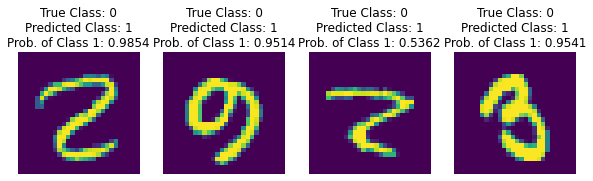

False Negative:


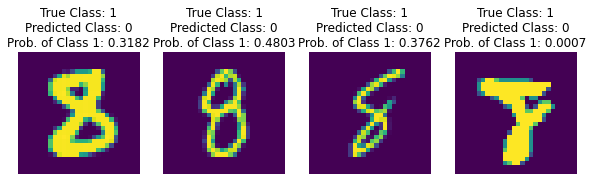

In [18]:
def show_classifications(images, labels, probabilities, result_type='TP'):
    """ Muestra ejemplos de imagenes para tipos de errores.
    
    Args:
        images: Array de dimensiones (n_ejemplos, n_pixeles) con imagenes.
        labels: Array de dimensiones (n_ejemplos,) con las etiquetas reales.
        probabilities: Array de dimensiones (n_ejemplos,) con las probabilidades
            de la clase 1.
        result_type: 'TP', 'FP', 'FN', o 'TP', tipo de error a mostrar.
    """
    dict_types = {'TN': 0, 'FP': 1, 'FN': 2, 'TP': 3}
    predictions = (probabilities > 0.5).long()
    encoded_data = 2 * labels + predictions 
    useful = np.where(encoded_data == dict_types[result_type])[0]
    size = min(4, useful.shape[0])
    chosen = np.random.choice(useful, size=size, replace=False)
    fig, ax = plt.subplots(1, 4, figsize=(10,4))
    fig.set_facecolor('white')
    for i, idx in enumerate(chosen):
        image = images[idx, :]
        digit = labels[idx]
        predicted_label = predictions[idx]
        proba = probabilities[idx]
        ax[i].imshow(image.reshape((28, 28)))
        ax[i].set_title("True Class: %d\nPredicted Class: %d\nProb. of Class 1: %1.4f"
                        % (digit, predicted_label, proba))
        ax[i].axis('off')
    for j in range(i+1, 4):
        ax[j].axis('off')

    plt.show()


test_probabilities = model(X_test).reshape(-1)

print('True Positives:')
show_classifications(X_test, y_test, test_probabilities , result_type='TP')

print('True Negatives:')
show_classifications(X_test, y_test, test_probabilities , result_type='TN')

print('False Positive:')
show_classifications(X_test, y_test, test_probabilities , result_type='FP')

print('False Negative:')
show_classifications(X_test, y_test, test_probabilities , result_type='FN')

## Experimento 1

In [19]:
#Funciones auxiliares
def experimento(lr, early_stopping_tolerance, criterion, run_n_times = 5, N=25):
    epochs = 100
    batch_size = 32
    use_gpu = False
    curves_history = []
    for run in range(run_n_times):
        print(f"Entrenando corrida número {run + 1}/{run_n_times}")
        # ----- Creacion de MLP
        model = MLPClassifier(
            n_features=28 * 28,
            layer_sizes=[N],
        )

        # ----- Entrenamiento de MLP
        curves = train_model(
            model,
            train_mnist_dataset,
            val_mnist_dataset,
            max_epochs=epochs,
            criterion=criterion,
            batch_size=batch_size,
            lr=lr,
            early_stopping_tolerance=early_stopping_tolerance,
            use_gpu=use_gpu
        )

        print()

        curves_history.append(curves)
    return curves_history, model #ultimo model


def tasa_de_acierto(curves_history):
    val_acc_history = np.array([run['val_acc'][-1] for run in curves_history])
    val_acc_mean = val_acc_history.mean()
    val_acc_std = val_acc_history.std()
    print('Final validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
    print(val_acc_history)

    train_acc_history = np.array([run['train_acc'][-1] for run in curves_history])
    train_acc_mean = train_acc_history.mean()
    train_acc_std = train_acc_history.std()
    print('Final train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
    print(train_acc_history)


def plot_curves(curves_history):
    # Obtenemos las curvas del último entrenamiento y las mostramos
    last_curves = curves_history[-1]

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(last_curves["val_loss"])) + 1

    ax[0].plot(epochs, last_curves['val_loss'], label='validation')
    ax[0].plot(epochs, last_curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, last_curves['val_acc'], label='validation')
    ax[1].plot(epochs, last_curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.32038195622501087, Train acc: 0.8714232444763184, Val loss: 0.2148805558681488, Val acc: 0.9265872836112976
Epoch 2/100 - Batch 334/335 - Train loss: 0.1915584033327316, Train acc: 0.9309893250465393, Val loss: 0.1691204458475113, Val acc: 0.9295634627342224
Epoch 3/100 - Batch 334/335 - Train loss: 0.13864684354569484, Train acc: 0.9504395127296448, Val loss: 0.2633574604988098, Val acc: 0.913690447807312
Epoch 4/100 - Batch 334/335 - Train loss: 0.10902265475979492, Train acc: 0.9613801836967468, Val loss: 0.14338836073875427, Val acc: 0.9484127163887024
Epoch 5/100 - Batch 334/335 - Train loss: 0.08619692380081362, Train acc: 0.9686740040779114, Val loss: 0.09025472402572632, Val acc: 0.971230149269104
Epoch 6/100 - Batch 334/335 - Train loss: 0.0740794887641139, Train acc: 0.9755002856254578, Val loss: 0.0860486775636673, Val acc: 0.9672619104385376
Epoch 7/100 - Batch 334/335 - Train loss: 0.0635254181031860

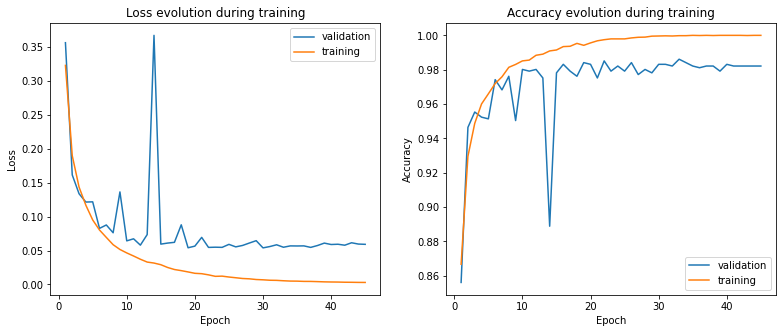

In [20]:
#Parametros de entrada
lr = 1e-1
early_stopping_tolerance = 15
criterion = nn.BCELoss() #Función de costo

curves_history, model=experimento(lr, early_stopping_tolerance, criterion)
print('Tasas de acierto:')
tasa_de_acierto(curves_history)
print(' ')
print('Curvas de aprendizaje:')
plot_curves(curves_history)
print(' ')

In [21]:
#Estadísticas de desempeño final
X_train, y_train = train_mnist_dataset[:]
X_val, y_val = val_mnist_dataset[:]
X_test, y_test = test_mnist_dataset[:]

train_probabilities = model(X_train).reshape(-1)
val_probabilities = model(X_val).reshape(-1)
test_probabilities = model(X_test).reshape(-1)

train_predicted_labels = (train_probabilities > 0.5).long()
val_predicted_labels = (val_probabilities > 0.5).long()
test_predicted_labels = (test_probabilities > 0.5).long()

TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()

print('Training results:')
TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Validation results:')
TN, FP, FN, TP = confusion_matrix(y_val, val_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Test results:')
TN, FP, FN, TP = confusion_matrix(y_test, test_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

Training results:
TP: 5347, TN: 5347, FP: 0, FN: 0
100.0000 Accuracy (Porcentaje de clasificaciones correctas)
100.0000 Precision
100.0000 Recall

Validation results:
TP: 494, TN: 496, FP: 8, FN: 10
98.2143 Accuracy (Porcentaje de clasificaciones correctas)
98.4064 Precision
98.0159 Recall

Test results:
TP: 957, TN: 954, FP: 20, FN: 17
98.1006 Accuracy (Porcentaje de clasificaciones correctas)
97.9529 Precision
98.2546 Recall



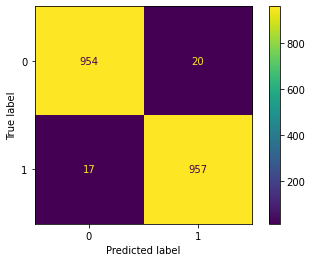

In [22]:
# Graficamos la matriz de confusión de los datos de test
ConfusionMatrixDisplay.from_predictions(y_test, test_predicted_labels)
plt.show()

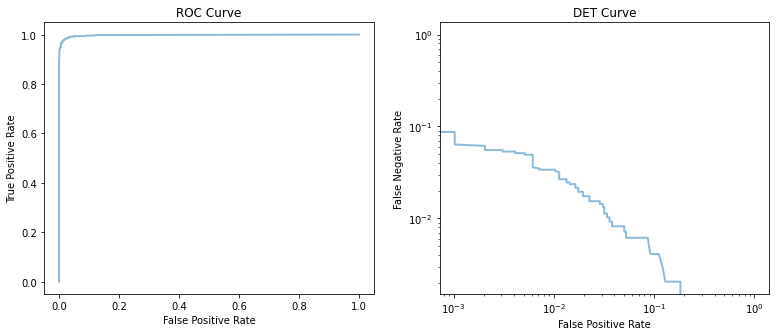

In [23]:
# Graficamos la curva ROC en test
tpr, fpr = roc_curve(y_test, test_probabilities)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

ax[0].set_title('ROC Curve')
ax[0].plot(fpr, tpr, linewidth=2, alpha=0.5)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[1].set_title('DET Curve')
ax[1].plot(fpr, 1.0 - tpr, linewidth=2, alpha=0.5)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('False Negative Rate')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

In [24]:
#Performance según umbral de clasificación
threshold = 0.5
TN, FP, FN, TP = conf_matrix_given_threshold(y_val, val_probabilities, threshold=threshold)
print(f"Threshold: {threshold} | TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

Threshold: 0.5 | TP: 494, TN: 496, FP: 8, FN: 10


True Positives:


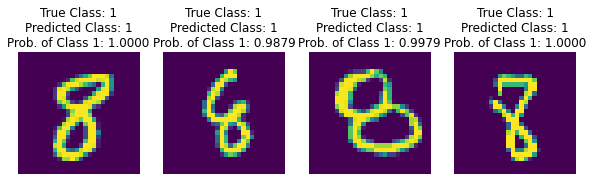

True Negatives:


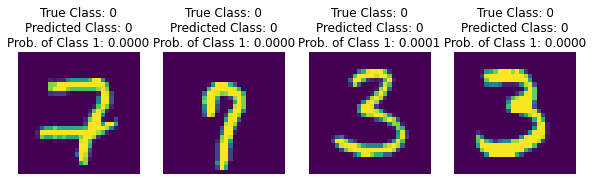

False Positive:


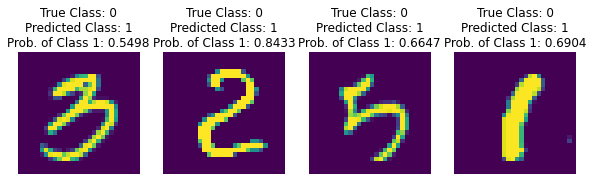

False Negative:


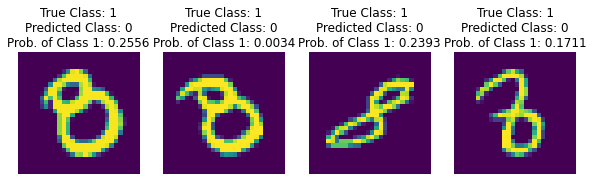

In [25]:
#Visualización de clasificaciones en el test
print('True Positives:')
show_classifications(X_test, y_test, test_probabilities , result_type='TP')

print('True Negatives:')
show_classifications(X_test, y_test, test_probabilities , result_type='TN')

print('False Positive:')
show_classifications(X_test, y_test, test_probabilities , result_type='FP')

print('False Negative:')
show_classifications(X_test, y_test, test_probabilities , result_type='FN')

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.11995240431000938, Train acc: 0.8515055179595947, Val loss: 0.07990562170743942, Val acc: 0.9027777910232544
Epoch 2/100 - Batch 334/335 - Train loss: 0.07591764952209014, Train acc: 0.9036843180656433, Val loss: 0.0647992268204689, Val acc: 0.9246031641960144
Epoch 3/100 - Batch 334/335 - Train loss: 0.062296040422880825, Train acc: 0.9242565631866455, Val loss: 0.05565323308110237, Val acc: 0.9295634627342224
Epoch 4/100 - Batch 334/335 - Train loss: 0.05227082829310823, Train acc: 0.9367870092391968, Val loss: 0.04634161293506622, Val acc: 0.9503968358039856
Epoch 5/100 - Batch 334/335 - Train loss: 0.04573099422616078, Train acc: 0.9447353482246399, Val loss: 0.04413969814777374, Val acc: 0.942460298538208
Epoch 6/100 - Batch 334/335 - Train loss: 0.03983569357460782, Train acc: 0.9529643058776855, Val loss: 0.03857957199215889, Val acc: 0.9603174328804016
Epoch 7/100 - Batch 334/335 - Train loss: 0.035100356

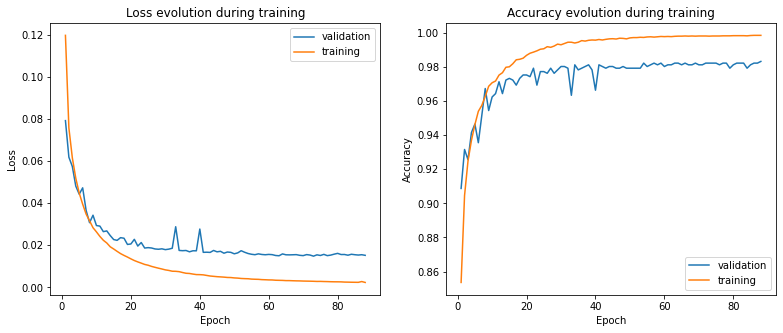

In [26]:
#Parametros de entrada
lr = 1e-1
early_stopping_tolerance = 15
criterion = nn.MSELoss() #Función de costo

curves_history, model=experimento(lr, early_stopping_tolerance, criterion)
print('Tasas de acierto:')
tasa_de_acierto(curves_history)
print(' ')
print('Curvas de aprendizaje:')
plot_curves(curves_history)
print(' ')

In [27]:
#Estadísticas de desempeño final
X_train, y_train = train_mnist_dataset[:]
X_val, y_val = val_mnist_dataset[:]
X_test, y_test = test_mnist_dataset[:]

train_probabilities = model(X_train).reshape(-1)
val_probabilities = model(X_val).reshape(-1)
test_probabilities = model(X_test).reshape(-1)

train_predicted_labels = (train_probabilities > 0.5).long()
val_predicted_labels = (val_probabilities > 0.5).long()
test_predicted_labels = (test_probabilities > 0.5).long()

TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()

print('Training results:')
TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Validation results:')
TN, FP, FN, TP = confusion_matrix(y_val, val_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Test results:')
TN, FP, FN, TP = confusion_matrix(y_test, test_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

Training results:
TP: 5340, TN: 5337, FP: 10, FN: 7
99.8410 Accuracy (Porcentaje de clasificaciones correctas)
99.8131 Precision
99.8691 Recall

Validation results:
TP: 491, TN: 500, FP: 4, FN: 13
98.3135 Accuracy (Porcentaje de clasificaciones correctas)
99.1919 Precision
97.4206 Recall

Test results:
TP: 955, TN: 957, FP: 17, FN: 19
98.1520 Accuracy (Porcentaje de clasificaciones correctas)
98.2510 Precision
98.0493 Recall



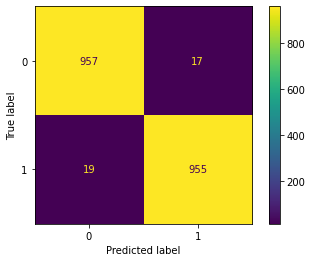

In [28]:
# Graficamos la matriz de confusión de los datos de test
ConfusionMatrixDisplay.from_predictions(y_test, test_predicted_labels)
plt.show()

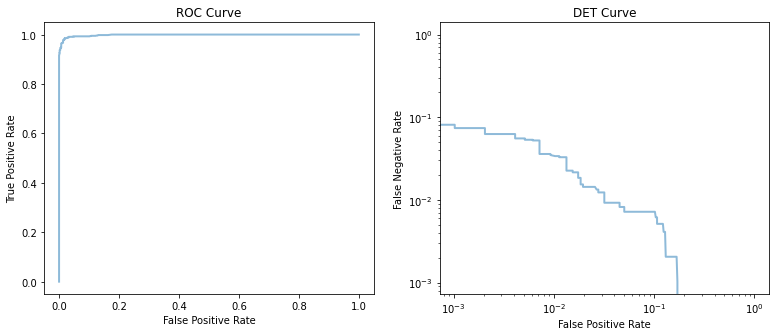

In [29]:
# Graficamos la curva ROC en test
tpr, fpr = roc_curve(y_test, test_probabilities)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

ax[0].set_title('ROC Curve')
ax[0].plot(fpr, tpr, linewidth=2, alpha=0.5)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[1].set_title('DET Curve')
ax[1].plot(fpr, 1.0 - tpr, linewidth=2, alpha=0.5)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('False Negative Rate')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

In [30]:
#Performance según umbral de clasificación
threshold = 0.5
TN, FP, FN, TP = conf_matrix_given_threshold(y_val, val_probabilities, threshold=threshold)
print(f"Threshold: {threshold} | TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

Threshold: 0.5 | TP: 491, TN: 500, FP: 4, FN: 13


True Positives:


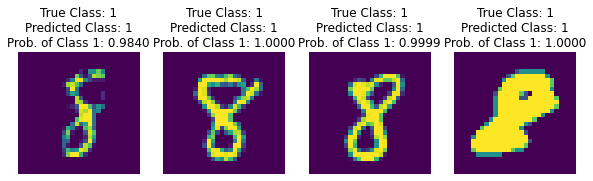

True Negatives:


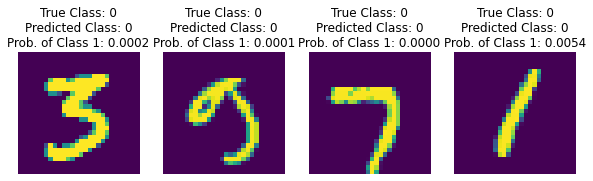

False Positive:


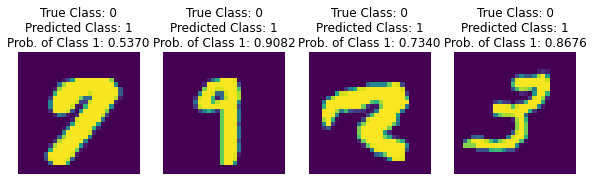

False Negative:


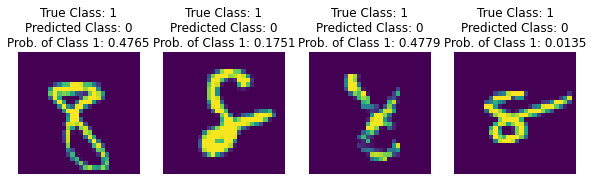

In [31]:
#Visualización de clasificaciones en el test
print('True Positives:')
show_classifications(X_test, y_test, test_probabilities , result_type='TP')

print('True Negatives:')
show_classifications(X_test, y_test, test_probabilities , result_type='TN')

print('False Positive:')
show_classifications(X_test, y_test, test_probabilities , result_type='FP')

print('False Negative:')
show_classifications(X_test, y_test, test_probabilities , result_type='FN')

## Experimento 2

Comienza entrenamiento con lr = 0.01
 
Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.5591252984395668, Train acc: 0.755470335483551, Val loss: 0.43338021636009216, Val acc: 0.8442460298538208
Epoch 2/100 - Batch 334/335 - Train loss: 0.37820630264816, Train acc: 0.8505704402923584, Val loss: 0.33247071504592896, Val acc: 0.8710317611694336
Epoch 3/100 - Batch 334/335 - Train loss: 0.3180549749687536, Train acc: 0.8750701546669006, Val loss: 0.29338744282722473, Val acc: 0.8938491940498352
Epoch 4/100 - Batch 334/335 - Train loss: 0.28872216648575083, Train acc: 0.8892837166786194, Val loss: 0.26974689960479736, Val acc: 0.908730149269104
Epoch 5/100 - Batch 334/335 - Train loss: 0.26872604220215957, Train acc: 0.8999438881874084, Val loss: 0.2520420253276825, Val acc: 0.9146825671195984
Epoch 6/100 - Batch 334/335 - Train loss: 0.25231276176758666, Train acc: 0.9053674936294556, Val loss: 0.2382507622241974, Val acc: 0.9226190447807312
Epoch 7/100 - Batch 33

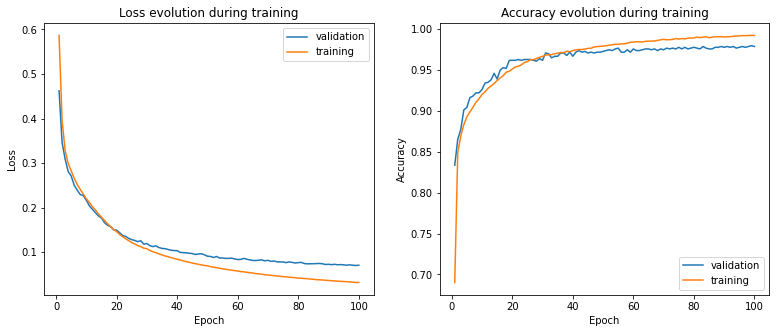

 
Comienza entrenamiento con lr = 0.1
 
Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.31804527453522186, Train acc: 0.8697400689125061, Val loss: 0.20309002697467804, Val acc: 0.9355158805847168
Epoch 2/100 - Batch 334/335 - Train loss: 0.1805132541193891, Train acc: 0.9350103139877319, Val loss: 0.17731426656246185, Val acc: 0.9305555820465088
Epoch 3/100 - Batch 334/335 - Train loss: 0.13108925135222388, Train acc: 0.9544604420661926, Val loss: 0.12422757595777512, Val acc: 0.9642857313156128
Epoch 4/100 - Batch 334/335 - Train loss: 0.10261344417318034, Train acc: 0.9650270938873291, Val loss: 0.10886728018522263, Val acc: 0.9642857313156128
Epoch 5/100 - Batch 334/335 - Train loss: 0.08820513676184771, Train acc: 0.9697026610374451, Val loss: 0.10273559391498566, Val acc: 0.9692460298538208
Epoch 6/100 - Batch 334/335 - Train loss: 0.07431180390404231, Train acc: 0.9748457074165344, Val loss: 0.09261249750852585, Val acc: 0.9642857313156128
Epoch 7/100 -

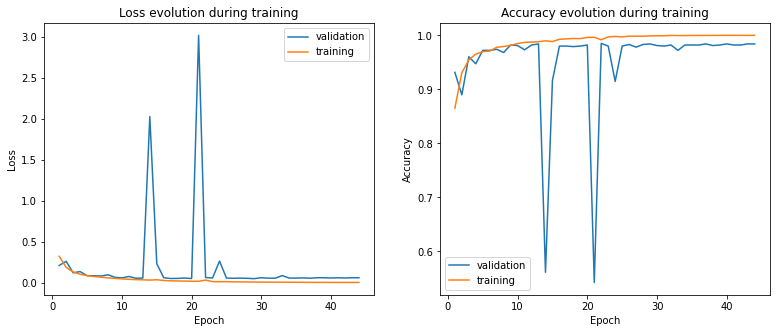

 
Comienza entrenamiento con lr = 1.0
 
Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.5100370107746836, Train acc: 0.7572470307350159, Val loss: 0.39328649640083313, Val acc: 0.8958333134651184
Epoch 2/100 - Batch 334/335 - Train loss: 0.32065131054885354, Train acc: 0.8832990527153015, Val loss: 0.5301848649978638, Val acc: 0.7301587462425232
Epoch 3/100 - Batch 334/335 - Train loss: 0.2931138675715496, Train acc: 0.9001309275627136, Val loss: 0.31039541959762573, Val acc: 0.89682537317276
Epoch 4/100 - Batch 334/335 - Train loss: 0.2470565465626432, Train acc: 0.9184589385986328, Val loss: 0.5479329228401184, Val acc: 0.8660714030265808
Epoch 5/100 - Batch 334/335 - Train loss: 0.21220318224114268, Train acc: 0.9285580515861511, Val loss: 0.23940011858940125, Val acc: 0.932539701461792
Epoch 6/100 - Batch 334/335 - Train loss: 0.2005611323487403, Train acc: 0.9304282665252686, Val loss: 0.3250811994075775, Val acc: 0.9107142686843872
Epoch 7/100 - Batch 33

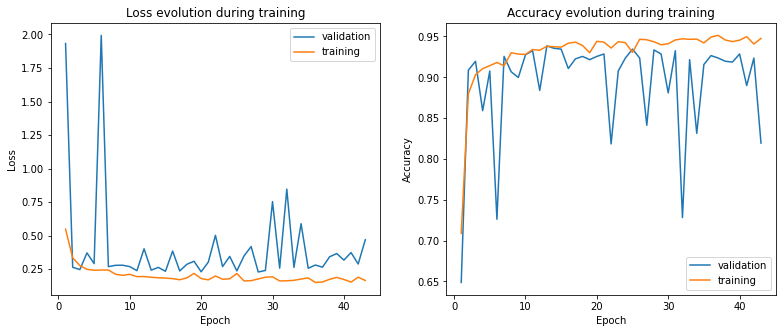

 
Comienza entrenamiento con lr = 10
 
Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 49.72569345662843, Train acc: 0.5000935196876526, Val loss: 50.0, Val acc: 0.5
Epoch 2/100 - Batch 334/335 - Train loss: 49.919154226957865, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 3/100 - Batch 334/335 - Train loss: 50.0404228779807, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 4/100 - Batch 334/335 - Train loss: 50.0404228779807, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 5/100 - Batch 334/335 - Train loss: 49.95957711063214, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 6/100 - Batch 334/335 - Train loss: 50.0, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 7/100 - Batch 334/335 - Train loss: 49.95957711063214, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 8/100 - Batch 334/335 - Train loss: 49.95957711063214, Train acc: 0.5, Val loss: 50.0, Val acc: 0.5
Epoch 9/100 - Batch 334/335 - Train loss: 50.0, Train acc: 0.5, Val loss: 50.0, Va

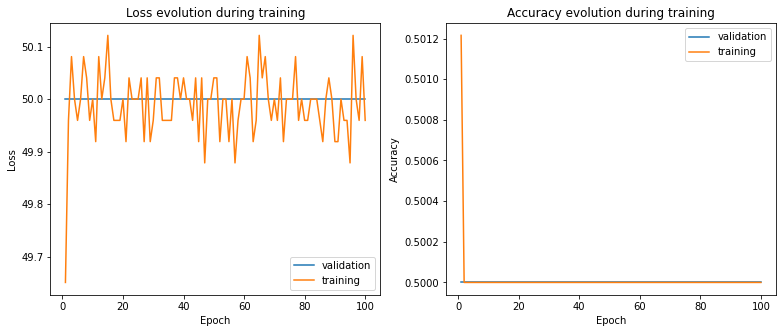

In [32]:
#Parametros de entrada
learning_rates=[0.01, 0.1, 1.0, 10]
early_stopping_tolerance = 15
criterion = nn.BCELoss() 

for lr in learning_rates:
  print('Comienza entrenamiento con lr =',lr)
  print(' ')
  curves_history, model=experimento(lr, early_stopping_tolerance, criterion)
  print('Tasas de acierto:')
  tasa_de_acierto(curves_history)
  print(' ')
  print('Curvas de aprendizaje:')
  plot_curves(curves_history)
  print(' ')

## Experimento 3

Comienza entrenamiento con N = 1
 
Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.3181866194107639, Train acc: 0.873760998249054, Val loss: 0.20515158772468567, Val acc: 0.9305555820465088
Epoch 2/100 - Batch 334/335 - Train loss: 0.18737150564122557, Train acc: 0.9321114420890808, Val loss: 0.3678539991378784, Val acc: 0.8402777910232544
Epoch 3/100 - Batch 334/335 - Train loss: 0.13377849042638024, Train acc: 0.9523097276687622, Val loss: 0.15976251661777496, Val acc: 0.9434523582458496
Epoch 4/100 - Batch 334/335 - Train loss: 0.10805879003132013, Train acc: 0.9616607427597046, Val loss: 0.11502057313919067, Val acc: 0.9573412537574768
Epoch 5/100 - Batch 334/335 - Train loss: 0.0881447694083648, Train acc: 0.971011757850647, Val loss: 0.13917063176631927, Val acc: 0.9573412537574768
Epoch 6/100 - Batch 334/335 - Train loss: 0.07584159704787073, Train acc: 0.9736300706863403, Val loss: 0.0891648679971695, Val acc: 0.971230149269104
Epoch 7/100 - Batch 334/

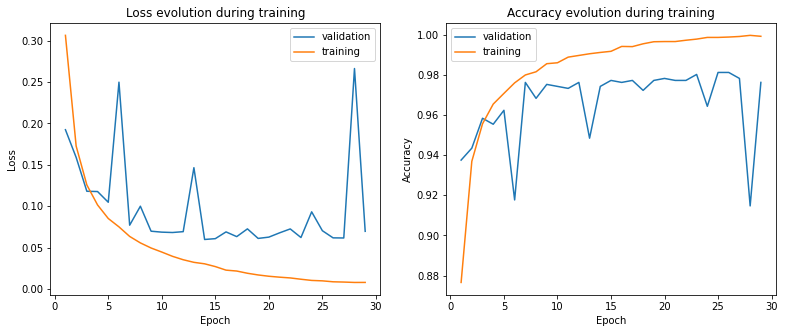

 
Estadísticas de desempeño final
 
Training results:
TP: 5340, TN: 5346, FP: 1, FN: 7
99.9252 Accuracy (Porcentaje de clasificaciones correctas)
99.9813 Precision
99.8691 Recall

Validation results:
TP: 491, TN: 493, FP: 11, FN: 13
97.6190 Accuracy (Porcentaje de clasificaciones correctas)
97.8088 Precision
97.4206 Recall

Test results:
TP: 957, TN: 961, FP: 13, FN: 17
98.4600 Accuracy (Porcentaje de clasificaciones correctas)
98.6598 Precision
98.2546 Recall

 
Comienza entrenamiento con N = 10
 
Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.32314107378027335, Train acc: 0.8684309124946594, Val loss: 0.38417086005210876, Val acc: 0.8273809552192688
Epoch 2/100 - Batch 334/335 - Train loss: 0.18053544396117552, Train acc: 0.9353843331336975, Val loss: 0.15351498126983643, Val acc: 0.9513888955116272
Epoch 3/100 - Batch 334/335 - Train loss: 0.13101197410541685, Train acc: 0.9544604420661926, Val loss: 0.24166887998580933, Val acc: 0.9017857313156128
Epoch 4

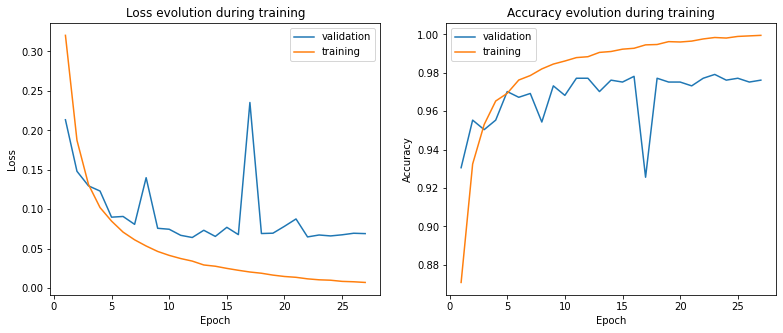

 
Estadísticas de desempeño final
 
Training results:
TP: 5346, TN: 5346, FP: 1, FN: 1
99.9813 Accuracy (Porcentaje de clasificaciones correctas)
99.9813 Precision
99.9813 Recall

Validation results:
TP: 494, TN: 490, FP: 14, FN: 10
97.6190 Accuracy (Porcentaje de clasificaciones correctas)
97.2441 Precision
98.0159 Recall

Test results:
TP: 961, TN: 955, FP: 19, FN: 13
98.3573 Accuracy (Porcentaje de clasificaciones correctas)
98.0612 Precision
98.6653 Recall

 
Comienza entrenamiento con N = 25
 
Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.32247303945304295, Train acc: 0.8674022555351257, Val loss: 0.21029673516750336, Val acc: 0.9315476417541504
Epoch 2/100 - Batch 334/335 - Train loss: 0.1810180736344252, Train acc: 0.9329530596733093, Val loss: 0.1401965171098709, Val acc: 0.9523809552192688
Epoch 3/100 - Batch 334/335 - Train loss: 0.12951467461995225, Train acc: 0.955115020275116, Val loss: 0.11285030841827393, Val acc: 0.966269850730896
Epoch 4/100

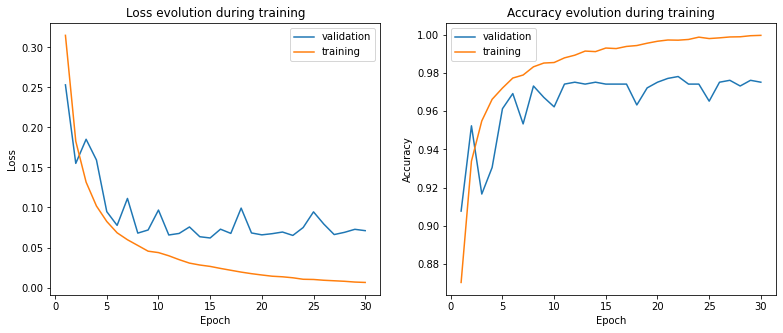

 
Estadísticas de desempeño final
 
Training results:
TP: 5346, TN: 5346, FP: 1, FN: 1
99.9813 Accuracy (Porcentaje de clasificaciones correctas)
99.9813 Precision
99.9813 Recall

Validation results:
TP: 491, TN: 492, FP: 12, FN: 13
97.5198 Accuracy (Porcentaje de clasificaciones correctas)
97.6143 Precision
97.4206 Recall

Test results:
TP: 954, TN: 958, FP: 16, FN: 20
98.1520 Accuracy (Porcentaje de clasificaciones correctas)
98.3505 Precision
97.9466 Recall

 
Comienza entrenamiento con N = 100
 
Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.3153238428395186, Train acc: 0.875724732875824, Val loss: 0.23914237320423126, Val acc: 0.9166666865348816
Epoch 2/100 - Batch 334/335 - Train loss: 0.17445278596967015, Train acc: 0.9375350475311279, Val loss: 0.14416709542274475, Val acc: 0.9553571343421936
Epoch 3/100 - Batch 334/335 - Train loss: 0.13155393021653838, Train acc: 0.9548344612121582, Val loss: 0.12932932376861572, Val acc: 0.9573412537574768
Epoch 4/

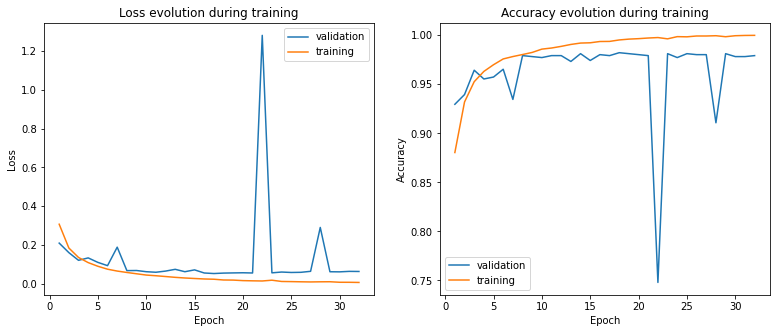

 
Estadísticas de desempeño final
 
Training results:
TP: 5345, TN: 5347, FP: 0, FN: 2
99.9813 Accuracy (Porcentaje de clasificaciones correctas)
100.0000 Precision
99.9626 Recall

Validation results:
TP: 493, TN: 494, FP: 10, FN: 11
97.9167 Accuracy (Porcentaje de clasificaciones correctas)
98.0119 Precision
97.8175 Recall

Test results:
TP: 956, TN: 960, FP: 14, FN: 18
98.3573 Accuracy (Porcentaje de clasificaciones correctas)
98.5567 Precision
98.1520 Recall

 


In [33]:
#Parametros de entrada
lr = 1e-1
early_stopping_tolerance = 15
criterion = nn.BCELoss() 
N_neuronas=[1, 10, 25, 100]

for N in N_neuronas:
  print('Comienza entrenamiento con N =',N)
  print(' ')
  curves_history, model=experimento(lr, early_stopping_tolerance, criterion)
  print('Tasas de acierto:')
  tasa_de_acierto(curves_history)
  print(' ')
  print('Curvas de aprendizaje:')
  plot_curves(curves_history)
  print(' ')

  print('Estadísticas de desempeño final')
  print(' ')
  X_train, y_train = train_mnist_dataset[:]
  X_val, y_val = val_mnist_dataset[:]
  X_test, y_test = test_mnist_dataset[:]

  train_probabilities = model(X_train).reshape(-1)
  val_probabilities = model(X_val).reshape(-1)
  test_probabilities = model(X_test).reshape(-1)

  train_predicted_labels = (train_probabilities > 0.5).long()
  val_predicted_labels = (val_probabilities > 0.5).long()
  test_predicted_labels = (test_probabilities > 0.5).long()

  TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()

  print('Training results:')
  TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()
  accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

  print('Validation results:')
  TN, FP, FN, TP = confusion_matrix(y_val, val_predicted_labels).ravel()
  accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

  print('Test results:')
  TN, FP, FN, TP = confusion_matrix(y_test, test_predicted_labels).ravel()
  accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)
  print(' ')

Entrenando corrida número 1/1
Epoch 1/100 - Batch 334/335 - Train loss: 0.30633534330930284, Train acc: 0.8793715834617615, Val loss: 0.20381604135036469, Val acc: 0.9375
Epoch 2/100 - Batch 334/335 - Train loss: 0.15877469036894948, Train acc: 0.9440807700157166, Val loss: 0.1191413551568985, Val acc: 0.9573412537574768
Epoch 3/100 - Batch 334/335 - Train loss: 0.11120624622302269, Train acc: 0.9617542624473572, Val loss: 0.10647327452898026, Val acc: 0.961309552192688
Epoch 4/100 - Batch 334/335 - Train loss: 0.0892215378971687, Train acc: 0.9697961211204529, Val loss: 0.08644018322229385, Val acc: 0.9742063283920288
Epoch 5/100 - Batch 334/335 - Train loss: 0.07328600036397354, Train acc: 0.9751262664794922, Val loss: 0.3328997492790222, Val acc: 0.8710317611694336
Epoch 6/100 - Batch 334/335 - Train loss: 0.06160445879700024, Train acc: 0.9798017740249634, Val loss: 0.1172976866364479, Val acc: 0.9563491940498352
Epoch 7/100 - Batch 334/335 - Train loss: 0.05216305825595202, Train 

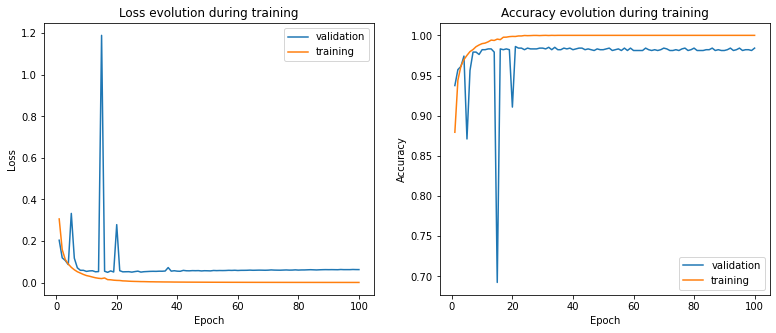

In [35]:
#Parametros de entrada
lr = 1e-1
early_stopping_tolerance = 100
criterion = nn.BCELoss() # ACÁ SE CAMBIA EL FUNCIONAL DE COSTO PARA EL EXPERIMENTO 1
run_n_times = 1
N=100

curves_history, model=experimento(lr, early_stopping_tolerance,  criterion, run_n_times, N)
print('Tasas de acierto:')
tasa_de_acierto(curves_history)
print(' ')
print('Curvas de aprendizaje:')
plot_curves(curves_history)
print(' ')

In [36]:
#Estadísticas del desempeño final
X_train, y_train = train_mnist_dataset[:]
X_val, y_val = val_mnist_dataset[:]
X_test, y_test = test_mnist_dataset[:]

train_probabilities = model(X_train).reshape(-1)
val_probabilities = model(X_val).reshape(-1)
test_probabilities = model(X_test).reshape(-1)

train_predicted_labels = (train_probabilities > 0.5).long()
val_predicted_labels = (val_probabilities > 0.5).long()
test_predicted_labels = (test_probabilities > 0.5).long()

TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()

print('Training results:')
TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Validation results:')
TN, FP, FN, TP = confusion_matrix(y_val, val_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Test results:')
TN, FP, FN, TP = confusion_matrix(y_test, test_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

Training results:
TP: 5347, TN: 5347, FP: 0, FN: 0
100.0000 Accuracy (Porcentaje de clasificaciones correctas)
100.0000 Precision
100.0000 Recall

Validation results:
TP: 497, TN: 495, FP: 9, FN: 7
98.4127 Accuracy (Porcentaje de clasificaciones correctas)
98.2213 Precision
98.6111 Recall

Test results:
TP: 957, TN: 957, FP: 17, FN: 17
98.2546 Accuracy (Porcentaje de clasificaciones correctas)
98.2546 Precision
98.2546 Recall



## Experimento 4

Entrenando corrida número 1/5
Epoch 1/100 - Batch 334/335 - Train loss: 0.3180654785748738, Train acc: 0.8672152757644653, Val loss: 0.19654592871665955, Val acc: 0.9444444179534912
Epoch 2/100 - Batch 334/335 - Train loss: 0.16876333476002536, Train acc: 0.9385637044906616, Val loss: 0.1819811463356018, Val acc: 0.9265872836112976
Epoch 3/100 - Batch 334/335 - Train loss: 0.1178077397367625, Train acc: 0.961567223072052, Val loss: 0.13269388675689697, Val acc: 0.9563491940498352
Epoch 4/100 - Batch 334/335 - Train loss: 0.09095255615217472, Train acc: 0.9694221019744873, Val loss: 0.0983644500374794, Val acc: 0.9642857313156128
Epoch 5/100 - Batch 334/335 - Train loss: 0.07425259272776433, Train acc: 0.9753132462501526, Val loss: 0.09188701957464218, Val acc: 0.9732142686843872
Epoch 6/100 - Batch 334/335 - Train loss: 0.06333022665427025, Train acc: 0.9790536761283875, Val loss: 0.07125502824783325, Val acc: 0.9791666865348816
Epoch 7/100 - Batch 334/335 - Train loss: 0.0521442523087

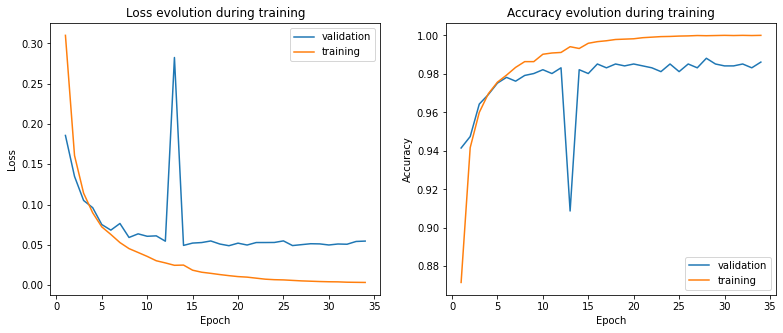

In [42]:
#Parametros de entrada
lr = 1e-1
early_stopping_tolerance = 15
criterion = nn.BCELoss() 
run_n_times = 5 
N=100

curves_history, model=experimento(lr, early_stopping_tolerance, criterion, run_n_times, N)
print('Tasas de acierto:')
tasa_de_acierto(curves_history)
print(' ')
print('Curvas de aprendizaje:')
plot_curves(curves_history)
print(' ')

In [43]:
#Estadísticas del desempeño final

X_train, y_train = train_mnist_dataset[:]
X_val, y_val = val_mnist_dataset[:]
X_test, y_test = test_mnist_dataset[:]

train_probabilities = model(X_train).reshape(-1)
val_probabilities = model(X_val).reshape(-1)
test_probabilities = model(X_test).reshape(-1)

train_predicted_labels = (train_probabilities > 0.5).long()
val_predicted_labels = (val_probabilities > 0.5).long()
test_predicted_labels = (test_probabilities > 0.5).long()

TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()

print('Training results:')
TN, FP, FN, TP = confusion_matrix(y_train, train_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Validation results:')
TN, FP, FN, TP = confusion_matrix(y_val, val_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Test results:')
TN, FP, FN, TP = confusion_matrix(y_test, test_predicted_labels).ravel()
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

Training results:
TP: 5346, TN: 5347, FP: 0, FN: 1
99.9906 Accuracy (Porcentaje de clasificaciones correctas)
100.0000 Precision
99.9813 Recall

Validation results:
TP: 496, TN: 498, FP: 6, FN: 8
98.6111 Accuracy (Porcentaje de clasificaciones correctas)
98.8048 Precision
98.4127 Recall

Test results:
TP: 954, TN: 963, FP: 11, FN: 20
98.4086 Accuracy (Porcentaje de clasificaciones correctas)
98.8601 Precision
97.9466 Recall



In [51]:
#Muestra de 1000 datos de y_test

L=len(y_test)
size=1000
index=np.random.choice(np.arange(L), size=size, replace=False)

sample_test_probabilities=np.zeros(size)
sample_y_test=np.zeros(size)
sample_X_test=np.zeros((size,784))

l=0
for i in index:
  sample_test_probabilities[l]=test_probabilities[i]
  sample_y_test[l]=y_test[i]
  sample_X_test[l,:]=X_test[i,:].numpy()
  l+=1

sample_test_probabilities=torch.from_numpy(sample_test_probabilities)
sample_y_test=torch.from_numpy(sample_y_test)
sample_X_test=torch.from_numpy(sample_X_test)

In [52]:
#Performance según umbral de clasificación
threshold = 0.998999
TN, FP, FN, TP = conf_matrix_given_threshold(sample_y_test, sample_test_probabilities, threshold=threshold)
print(f"Threshold: {threshold} | TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

Threshold: 0.998999 | TP: 402, TN: 493, FP: 0, FN: 105


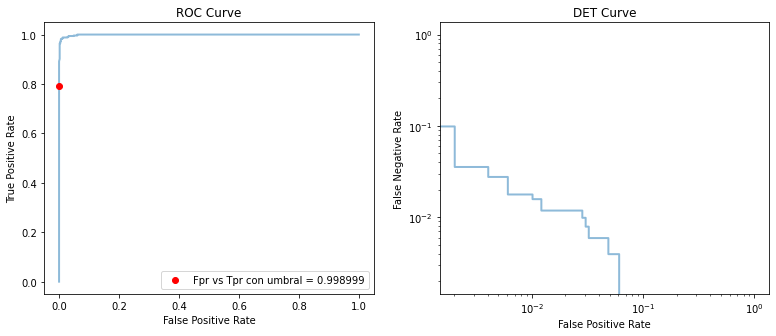

In [53]:
# Graficamos la curva ROC en test
tpr, fpr = roc_curve(sample_y_test, sample_test_probabilities)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

ax[0].set_title('ROC Curve')
ax[0].plot(fpr, tpr, linewidth=2, alpha=0.5)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].plot(fpr[-2], tpr[-2], 'o', c='r', label='Fpr vs Tpr con umbral = '+str(threshold))
ax[0].legend()

ax[1].set_title('DET Curve')
ax[1].plot(fpr, 1.0 - tpr, linewidth=2, alpha=0.5)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('False Negative Rate')
ax[1].set_yscale('log')
ax[1].set_xscale('log')